# Read Data and Split

In [1]:
# Load all helper function
%run -i 'source.py'

dataset = pd.read_feather("../processing/train_with_feature.feather")
X = dataset[numc_features + ohe_features + te_features]
y = dataset['is_attributed']

**Since the dataset is too big, we use only 500,000 rows to train and test our model.**

**We have 62,360,949 rows in our entire data. While building these models let's only have 500,000 rows. (That is .81% of the original data.)**

In [2]:
X, _, y, _ = train_test_split(X, y, random_state=4995, train_size=.0081, stratify=y)
print(len(X))

505123


In [3]:
X_dev, X_test, y_dev, y_test = train_test_split(X, y, random_state=4995, test_size=0.2, stratify=y)

In [4]:
print(f'Proportion of data in development set: {len(X_dev)/len(X):0.2f}')
print('Confirm we have a stratified split. 0 represents negative (no download); 1 represents positive (yes download)')
import numpy as np
print(f'Proportion of positives in entire data set: {np.mean(y):0.5f}')
print(f'Proportion of positives in development set: {np.mean(y_dev):0.5f}')
print(f'Proportion of positives in test set: {np.mean(y_test):0.5f}')

Proportion of data in development set: 0.80
Confirm we have a stratified split. 0 represents negative (no download); 1 represents positive (yes download)
Proportion of positives in entire data set: 0.00243
Proportion of positives in development set: 0.00243
Proportion of positives in test set: 0.00243


# SMOTE Development Dataset

In [5]:
print(f'Original development data distribution of labels: {Counter(y_dev)}')

Original development data distribution of labels: Counter({0: 403117, 1: 981})


In [6]:
print('We use SMOTE to balance our dataset.')
smote = SMOTE()
X_dev_SMOTE, y_dev_SMOTE = smote.fit_resample(X_dev, y_dev) # It is okay to do smote first since for now we are not doing any hyperparameter tuning.
print(f'After SMOTE our development data has the shape: {Counter(y_dev_SMOTE)}')

We use SMOTE to balance our dataset.
After SMOTE our development data has the shape: Counter({0: 403117, 1: 403117})


# Preprocessing

No scaling required for logistic regression.

# Build Model (no tuning)

In [7]:
lr = LogisticRegression(n_jobs = -1)
lr.fit(X_dev_SMOTE, y_dev_SMOTE)

LogisticRegression(n_jobs=-1)

In [8]:
lr_predictions = lr.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test,lr_predictions)}')
print(f'Recall: {recall_score(y_test,lr_predictions)}')
print(f'Precision: {precision_score(y_test,lr_predictions)}')
print(f'F-1 Score: {f1_score(y_test,lr_predictions)}')

recall, precision = recall_score(y_test,lr_predictions), precision_score(y_test,lr_predictions)

Accuracy: 0.835426874536006
Recall: 0.8367346938775511
Precision: 0.012208921446012745
F-1 Score: 0.02406668231979338


In [9]:
lr_prob_pred = lr.predict_proba(X_test)[:, 1]

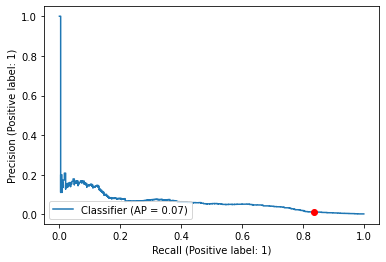

In [10]:
PrecisionRecallDisplay.from_predictions(y_test, lr_prob_pred)
plt.plot(recall,precision,'ro');

# Tune Hyperparameters since Recall was fine but Precision was terrible

**SMOTE must be part of the imblearn.pipeline so it isn't applied to the validation folds.**

In [11]:
from imblearn.pipeline import Pipeline
model = Pipeline([('sampling', SMOTE()),('classification', LogisticRegression(n_jobs=90, solver='saga'))])
parameter_grid = {'classification__penalty' : ['l1', 'l2'],'classification__C' : np.logspace(-4, 4, 10)}

lr_2 = GridSearchCV(model, parameter_grid, cv=5, n_jobs=-1, scoring=['recall','f1'],refit='f1')
lr_2.fit(X_dev, y_dev)

/root/miniconda3/envs/myconda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/root/miniconda3/envs/myconda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sampling', SMOTE()),
                                       ('classification',
                                        LogisticRegression(n_jobs=90,
                                                           solver='saga'))]),
             n_jobs=-1,
             param_grid={'classification__C': array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04]),
                         'classification__penalty': ['l1', 'l2']},
             refit='f1', scoring=['recall', 'f1'])

In [12]:
lr_2.best_params_

{'classification__C': 2.782559402207126, 'classification__penalty': 'l1'}

In [13]:
lr_2_predictions = lr_2.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test,lr_2_predictions)}')
print(f'Recall: {recall_score(y_test,lr_2_predictions)}')
print(f'Precision: {precision_score(y_test,lr_2_predictions)}')
print(f'F-1 Score: {f1_score(y_test,lr_2_predictions)}')

recall, precision = recall_score(y_test,lr_predictions), precision_score(y_test,lr_predictions)

Accuracy: 0.8364464241524375
Recall: 0.8408163265306122
Precision: 0.012342720191731577
F-1 Score: 0.02432831414230883


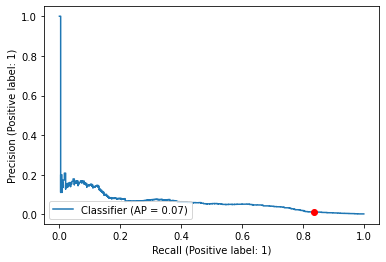

In [14]:
lr_2_prob_pred = lr.predict_proba(X_test)[:, 1]
PrecisionRecallDisplay.from_predictions(y_test, lr_prob_pred)
plt.plot(recall,precision,'ro');

**We see that tuning the regularization parameter did not help much at all. We still have terrible precision; let's move on to a different model.**

In [15]:
filename = '../processing/LogisticRegression.sav'
pickle.dump(lr_2, open(filename,'wb'))

In [17]:
# load the model from disk
filename = '../processing/LogisticRegression.sav'
loaded_model = pickle.load(open(filename, 'rb'))